In [1]:
from bs4 import BeautifulSoup
import requests
import datetime
#from datetime import date
#import time
#import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
#from pandas.plotting import table
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders

In [2]:
URL = 'https://worldometers.info/coronavirus/'

headers = {"User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36'}
page=requests.get(URL, headers=headers)
soup=BeautifulSoup(page.content, 'html.parser')

In [3]:
covid19_data = []   #initiate empty list to store data

web_table = soup.find('table')  #look for the table in web page

table_rows = web_table.find_all('tr')   #find rows

#iterate through rows and append contents of each row to the list
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    covid19_data.append(row)

covid19_data = covid19_data [1:] #remove blank/duplicate first row

In [4]:
# Get data from totals row. #Not needed, data available already within the panda df

tag = soup.find(class_="total_row")

total_rows = tag.find_all('td')
#print(total_rows)

total_row = [i.text for i in total_rows]
print(total_row)

#covid19_data.append(total_row)

['Total:', '1,287,168', '+14,306', '70,530', '+1,105', '271,887', '944,751', '46,045', '165.1', '9.0', '', '']


In [5]:
#convert data into a pandas data frame and insert headers
df = pd.DataFrame(covid19_data, columns = ['Country/Other', 'Total_Cases', 'New_Cases', 'Total_Deaths', 'New_Deaths', 'Total_Recovered', 'Active_Cases', 'Serious/Critical', 'Cases_per_1M', 'Deaths_per_1M', 'Total_Tests', 'Test_per_1M']) 
#df = pd.DataFrame(covid19_data, columns = ['Country/Other', 'Total_Cases', 'New_Cases', 'Total_Deaths', 'New_Deaths', 'Total_Recovered', 'Active_Cases', 'Serious/Critical', 'Cases_per_1M', 'Deaths_per_1M']) 

df.replace('', 0, inplace=True)  #replace all empty string with 0 (all except Total_Deaths)
df.replace(' ', 0, inplace=True) #replace  strings with just space with 0 (Total_Deaths)
#df.replace(np.nan, 0, inplace=True) #replace  nan with 0

df

,Country/Other,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious/Critical,Cases_per_1M,Deaths_per_1M,Total_Tests,Test_per_1M
0,World,"1,287,168","+14,306","70,530","+1,105","271,887","944,751","46,045",165,9.0,0,0
1,USA,"336,851",+178,"9,620",+4,"17,977","309,254","8,702","1,018",29,"1,772,369","5,355"
2,Spain,"135,032","+3,386","13,055",+414,"40,437","81,540","6,931","2,888",279,"355,000","7,593"
3,Italy,"128,948",0,"15,887",0,"21,815","91,246","3,977","2,133",263,"691,461","11,436"
4,Germany,"100,132",+9,"1,584",0,"28,700","69,848","3,936","1,195",19,"918,460","10,962"
...,...,...,...,...,...,...,...,...,...,...,...,...
207,Saint Pierre Miquelon,1,0,0,0,0,1,0,173,0,0,0
208,South Sudan,1,0,0,0,0,1,0,0.09,0,0,0
209,Timor-Leste,1,0,0,0,0,1,0,0.8,0,0,0
210,China,"81,708",+39,"3,331",+2,"77,078","1,299",265,57,2,0,0


In [6]:
df = df.drop(columns=['Total_Tests', 'Test_per_1M']) #dropping last two column as it is not used later

df.tail()

,Country/Other,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious/Critical,Cases_per_1M,Deaths_per_1M
207,Saint Pierre Miquelon,1,0,0,0,0,1,0,173,0
208,South Sudan,1,0,0,0,0,1,0,0.09,0
209,Timor-Leste,1,0,0,0,0,1,0,0.8,0
210,China,"81,708",+39,"3,331",+2,"77,078","1,299",265,57,2
211,Total:,"1,287,168","+14,306","70,530","+1,105","271,887","944,751","46,045",165.1,9.0


In [7]:
#convert object types to float 64 type to plot graphs
df['Total_Cases'] = df['Total_Cases'].str.replace(',','').astype(np.float64)
df['New_Cases'] = df['New_Cases'].str.replace(',','').astype(np.float64)
df['Total_Deaths'] = df['Total_Deaths'].str.replace(',','').astype(np.float64)
df['New_Deaths'] = df['New_Deaths'].str.replace(',','').astype(np.float64)
df['Total_Recovered'] = df['Total_Recovered'].str.replace(',','').astype(np.float64)
df['Active_Cases'] = df['Active_Cases'].str.replace(',','').astype(np.float64)
df['Serious/Critical'] = df['Serious/Critical'].str.replace(',','').astype(np.float64)
df['Cases_per_1M'] = df['Cases_per_1M'].str.replace(',','').astype(np.float64)
df['Deaths_per_1M'] = df['Deaths_per_1M'].str.replace(',','').astype(np.float64)

#df.dtypes

#sort countries with most cases
df=df.sort_values(by=['Total_Cases'], ascending = False)
df

,Country/Other,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious/Critical,Cases_per_1M,Deaths_per_1M
0,World,1287168.0,14306.0,70530.0,1105.0,271887.0,944751.0,46045.0,165.00,9.0
211,Total:,1287168.0,14306.0,70530.0,1105.0,271887.0,944751.0,46045.0,165.10,9.0
1,USA,336851.0,178.0,9620.0,4.0,17977.0,309254.0,8702.0,1018.00,29.0
2,Spain,135032.0,3386.0,13055.0,414.0,40437.0,81540.0,6931.0,2888.00,279.0
3,Italy,128948.0,NaN,15887.0,NaN,21815.0,91246.0,3977.0,2133.00,263.0
...,...,...,...,...,...,...,...,...,...,...
205,Falkland Islands,2.0,NaN,NaN,NaN,NaN,2.0,NaN,575.00,NaN
206,Papua New Guinea,2.0,1.0,NaN,NaN,NaN,2.0,NaN,0.20,NaN
207,Saint Pierre Miquelon,1.0,NaN,NaN,NaN,NaN,1.0,NaN,173.00,NaN
208,South Sudan,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.09,NaN


In [8]:
df1 = df[2:11] #take top 9 countries, avoid total and world at top
df2 = df[11:] 

others = df2.sum(axis = 0, skipna = True)

others['Country/Other']='Others'
#print(others)

#print(len(df[10:]))
others['Cases_per_1M']=others['Cases_per_1M']/len(df2) #average the value
others['Deaths_per_1M']=others['Deaths_per_1M']/len(df2) #average the value
#print(others)


df1 = df1.append(others, ignore_index=True) #append all other countries ('others') to df1
#print(df1)
#plot = df1.plot.pie(y='Total_Cases', figsize=(5, 5))

df3=df1[['Country/Other','Total_Cases','Active_Cases','Total_Deaths']] #data in pie chart , used for inserting table in plot

df2.tail()

,Country/Other,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious/Critical,Cases_per_1M,Deaths_per_1M
205,Falkland Islands,2.0,NaN,NaN,NaN,NaN,2.0,NaN,575.00,NaN
206,Papua New Guinea,2.0,1.0,NaN,NaN,NaN,2.0,NaN,0.20,NaN
207,Saint Pierre Miquelon,1.0,NaN,NaN,NaN,NaN,1.0,NaN,173.00,NaN
208,South Sudan,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.09,NaN
209,Timor-Leste,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.80,NaN


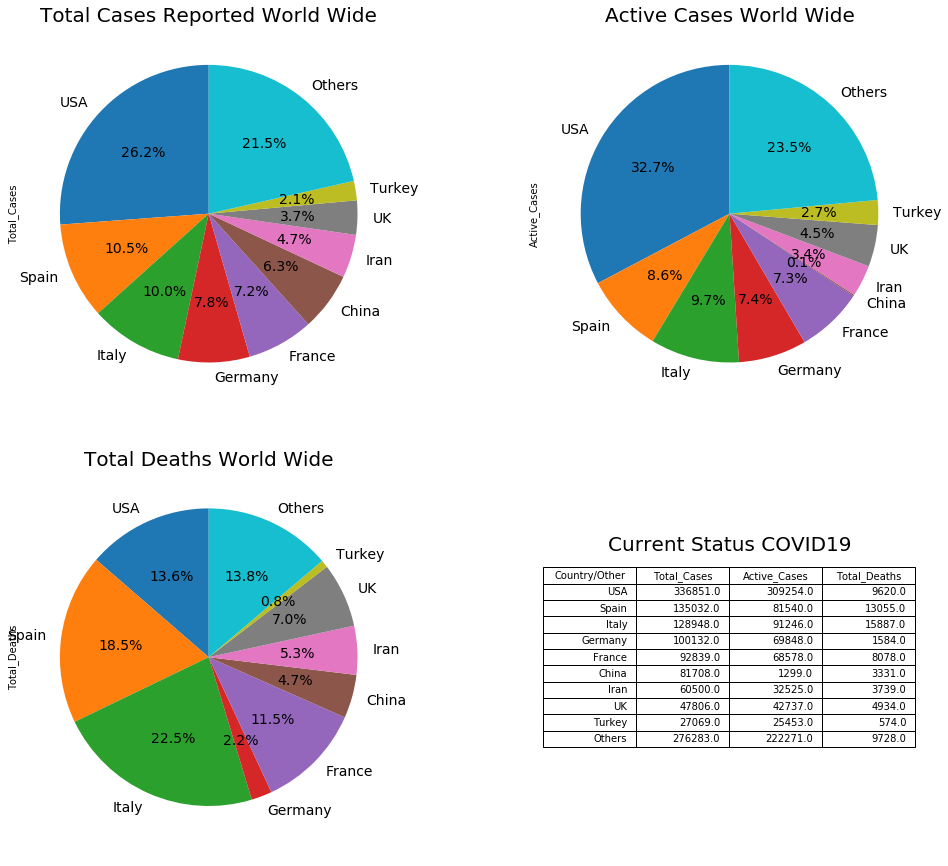

In [9]:
#plot pie charts

plt.figure(figsize=(16,12))

ax1 = plt.subplot(221, aspect='equal')
df1.plot(kind='pie', y = 'Total_Cases', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df1['Country/Other'], legend = False, fontsize=14)
plt.title('Total Cases Reported World Wide',fontsize=20)

ax2 = plt.subplot(222, aspect='equal')
df1.plot(kind='pie', y = 'Active_Cases', ax=ax2, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df1['Country/Other'], legend = False, fontsize=14)
plt.title('Active Cases World Wide',fontsize=20)

ax3 = plt.subplot(223, aspect='equal')
df1.plot(kind='pie', y = 'Total_Deaths', ax=ax3, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df1['Country/Other'], legend = False, fontsize=14)
plt.title('Total Deaths World Wide',fontsize=20)

#insert table in the plot
df3_text = []
for df3_row in range(len(df3)):
    df3_text.append(df3.iloc[df3_row])
plt.subplot(224)
plt.table(cellText=df3_text, colLabels=df3.columns, loc='center')
plt.axis('off')
plt.title('Current Status COVID19',fontsize=20, y=0.75)

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.4)
plt.savefig('COVID19.png', dpi=300)
plt.show()


In [ ]:
#send the plot as an email

right_now = str(datetime.datetime.now().strftime("%Y-%m-%d_%H:%M"))

# Open file with email details
file = open('email.txt',mode='r')
 
# read lines
all_lines = file.readlines()

# close the file
file.close()

email_user = all_lines[0]
email_password = all_lines[1]
email_send = all_lines[2]

subject = 'COVID19 Current Status'

msg = MIMEMultipart()
msg['From'] = email_user
msg['To'] = email_send
msg['Subject'] = subject

body = 'Hi, \n\nSending the status of COVID19 as of '+str(right_now)
msg.attach(MIMEText(body,'plain'))

filename='COVID19.png'
attachment  =open(filename,'rb')

part = MIMEBase('application','octet-stream')
part.set_payload((attachment).read())
encoders.encode_base64(part)
part.add_header('Content-Disposition',"attachment; filename= "+filename)

msg.attach(part)
text = msg.as_string()
server = smtplib.SMTP('smtp.gmail.com')
server.starttls()
server.login(email_user,email_password)


server.sendmail(email_user,email_send,text)
server.quit()